In [68]:
### script to check the normalization between WJets MC and data

import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections

from collections import OrderedDict
import uproot
import pandas as pd
import os
import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append(os.getenv('HOME')+'/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

import CMS_lumi, tdrstyle
a = tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2


# donotdelete = []
print(sys.version)

3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [69]:
fpath_bkg =OrderedDict()
tree_bkg = OrderedDict()
tree_sig = OrderedDict()
fpath_sig =OrderedDict()


start_t = time.time()

# with ncluster>0 selection
path = '/storage/af/group/phys_exotica/delayedjets/HNL/skim/'
fpath_bkg['data'] = path+ 'EGamma_2018A.root'
fpath_bkg['WJetsToLNu'] = path  + 'WJetsToLNu_1pb_weighted.root'

# no selection at all, only event-level variables stored
path = '/storage/af/group/phys_exotica/delayedjets/HNL/displacedJetMuonAnalyzer/V1p17/'
fpath_bkg['data'] = path+ 'Data2018/v5/v1/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2018_17Sept2018_AOD_Run2018A-17Sep2018_merged_goodLumi.root'
fpath_bkg['WJetsToLNu'] = path  + 'MC_Fall18/v1/v1/normalized/WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8_137000pb_weighted.root'


NEvents = {}
Total = {}
accep = {}
acc_met = {}
for k,v in fpath_bkg.items():
    print (k, v)
    root_dir = uproot.open(v) 
    tree_bkg[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
    a = tree_bkg[k]["weight"].array()
    print("NEvents",NEvents[k],np.sum(a))


data /storage/af/group/phys_exotica/delayedjets/HNL/displacedJetMuonAnalyzer/V1p17/Data2018/v5/v1/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2018_17Sept2018_AOD_Run2018A-17Sep2018_merged_goodLumi.root
NEvents 22403660.0 21576102.0
WJetsToLNu /storage/af/group/phys_exotica/delayedjets/HNL/displacedJetMuonAnalyzer/V1p17/MC_Fall18/v1/v1/normalized/WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8_137000pb_weighted.root
NEvents 36333430.0 7671851000.0


### load Wpt weights

In [70]:
path = os.getenv('HOME')+'/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/data/WPtWeights/'
target = uproot.open(path + 'wp-13tev-cms.root')['s_qt']
source = uproot.open(path + 'WPT.root')['Wpt']
  


### load branches

In [122]:

sel_ev = {}
weight = {}
weight_evt = {}
gWPt = {}
gWPtWeight = {}
met = {}
nCscRechitClusters3 = {}
nDtRechitClusters = {}
lepPt = {}
lepEta = {}
lepPhi = {}
weight_clusterEffCsc = {}
weight_clusterEffDt = {}
for k,T in tree_bkg.items():
    
########### SELECTION: LEPTON ############
    
    sel_ele = np.logical_and(T.array('lepPt') > 35, np.abs(T.array('lepEta'))<2.4)
    sel_ele = np.logical_and(sel_ele, np.abs(T.array('lepPdgId')) == 11)
    sel_ele = np.logical_and(sel_ele, np.abs(T.array('lepPassId')) == 1)
########### SELECTION: EVENTS ############
    # select only triggered events
    sel_ev[k] = T.array('SingleEleTrigger')
    sel_ev[k] = np.logical_and(sel_ev[k] ,sel_ele.sum()>=1)
    sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('metEENoise')>=30)
    
    sel_ev[k] = np.logical_and(sel_ev[k],T.array('Flag2_all'))
#     sel_ev[k] = np.logical_and(sel_ev[k],T.array('nCscRechitClusters3')>0)


#     sel_ev[k] = np.logical_and(sel_ev[k],T.array('nDtStations25')<3)
#     sel_ev[k] = np.logical_and(sel_ev[k],T.array('nDtWheels25')<3)
#     sel_ev[k]  = np.logical_and(sel_ev[k],sel_rechitcluster.sum() >= 1)
#     sel_ev[k] = np.logical_and(sel_ev[k],np.abs(T.array('jetMet_dPhiMin'))>0.6)
#     sel_ev[k] = np.sum(T.array('gLLP_dt'),axis = 1) >= 1
    
########### BRANCHES ############

   ##### event variables ##### 
    
    gWPt[k] = T.array('gWPt')
    if 'data' in k:
        weight[k] = T.array('weight')[sel_ev[k]]*0.0 + 1
        weight_clusterEffCsc[k] = T.array('weight')[sel_ev[k]]*0.0 + 1
        weight_clusterEffDt[k] = T.array('weight')[sel_ev[k]]*0.0 + 1
    else:
        weight[k] = (T.array('weight')*T.array('pileupWeight'))[sel_ev[k]]
        # correction of mismodelling of cluster efficiency, numbers are taken from ratio of events with 1 cluster/0 cluster bin
        weight_clusterEffDt[k] = 4.6**(T.array('nDtRechitClusters'))[sel_ev[k]]
        weight_clusterEffCsc[k] = 1.24**(T.array('nCscRechitClusters3'))[sel_ev[k]]

    gWPtWeight[k] = target.values[np.argmax(target.edges>gWPt[k][:,None],axis=1)-1]/11178549.542718 # integral
    gWPtWeight[k] /= source.values[np.argmax(source.edges>gWPt[k][:,None],axis=1)-1]
    gWPtWeight[k] = gWPtWeight[k][sel_ev[k]]
    if 'data' in k: print(k, '\t', np.sum(weight[k]))
    else:
        print(k, '\t', np.sum(weight[k])/137000*939)
        print(k, '\t', np.sum(weight[k]*gWPtWeight[k])/137000*939)
    met[k] = T.array('metEENoise')[sel_ev[k]]
    nCscRechitClusters3[k] = T.array('nCscRechitClusters3')[sel_ev[k]]
    nDtRechitClusters[k] = T.array('nDtRechitClusters')[sel_ev[k]]
    lepPt[k] = T.array('lepPt')[sel_ele][sel_ev[k]][:,0]
    lepEta[k] = T.array('lepEta')[sel_ele][sel_ev[k]][:,0]
    lepPhi[k] = T.array('lepPhi')[sel_ele][sel_ev[k]][:,0]


data 	 2467984.0
WJetsToLNu 	 1925223.8315912408
WJetsToLNu 	 2020422.812174888


# plot gWPt

[   0.    5.   10.   15.   20.   25.   30.   35.   40.   45.   50.   60.
   70.   80.   90.  100.  125.  150.  200.  300.  800. 1500.]
11178549.542717662


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


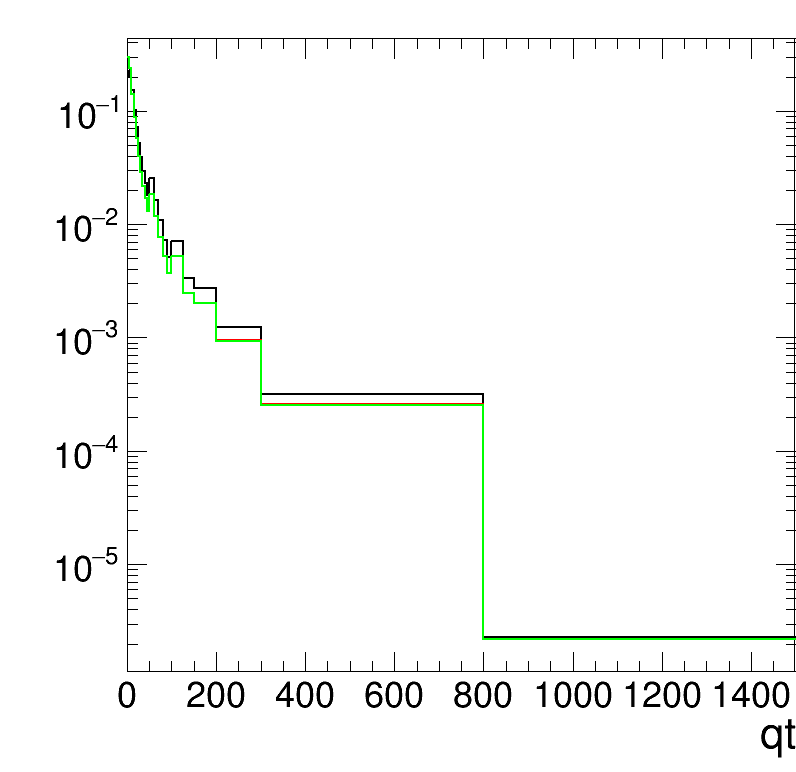

In [49]:
# Check WPT reweighting is done correctly


import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot


c = rt.TCanvas('c','c', 800, 800)
rt.gStyle.SetOptStat(0)
path = os.getenv('HOME')+'/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/data/WPtWeights/'
target_file = rt.TFile.Open(path + 'wp-13tev-cms.root', 'READ')
target_hist = target_file.Get('s_qt')

source_file = rt.TFile.Open(path + 'WPT.root', 'READ')
source_hist = source_file.Get('Wpt')
print(source.edges)
# source_mc = create_TH1D( gWPt['WJetsToLNu'][sel_ev['WJetsToLNu']], axis_title=['W pT [GeV]', 'Events'], name='gwpt', binning=source.edges, \
#                         weights = weight['WJetsToLNu']/np.sum(weight['WJetsToLNu']))

source_mc = create_TH1D( gWPt['WJetsToLNu'], axis_title=['W pT [GeV]', 'Events'], name='gwpt', binning=source.edges, weights = tree_bkg['WJetsToLNu'].array('weight'))


target_hist.SetLineColor(1)
source_hist.SetLineColor(2)
target_hist.SetLineWidth(2)
source_hist.SetLineWidth(2)

source_mc.SetLineColor(3)
# source_hist.SetLineColor(2)
source_mc.SetLineWidth(2)
# source_hist.SetLineWidth(2)



print(target_hist.Integral())
target_hist.Scale(1./target_hist.Integral())

source_mc.Scale(1./source_mc.Integral())

target_hist.Draw('hist')
source_hist.Draw('hist same')
source_mc.Draw('hist same')
# c = make_ratio_plot([source, target], fit = False, logy=True, in_tags = ["source","target"], ratio_bounds = [0,3], draw_opt = ['E1','E2'])



c.SetLogy()
c.SetRightMargin(0)
c.Draw()
# print(time.time()-start_t)

# Data/MC comparison

data 0.0
data 0.0
data 0.0
data 0.0
data 0.0
WJetsToLNu 0.0
WJetsToLNu 0.0
WJetsToLNu 0.0
WJetsToLNu 0.0
WJetsToLNu 0.0
data 0.0
data 0.0
data 0.0
data 868324.0
data 936391.0
WJetsToLNu 0.0
WJetsToLNu 0.0
WJetsToLNu 0.0
WJetsToLNu 832361.3917627189
WJetsToLNu 756310.2950603792
data 0.0
data 56921.0
data 55936.0
data 56916.0
data 57198.0
WJetsToLNu 0.0
WJetsToLNu 30901.481096644722
WJetsToLNu 34158.20743199015
WJetsToLNu 37339.153678590614
WJetsToLNu 39171.8447711111
data 0.0
data 0.0
data 22982.0
data 56894.0
data 60010.0
WJetsToLNu 0.0
WJetsToLNu 0.0
WJetsToLNu 18843.27949504202
WJetsToLNu 45941.490940088006
WJetsToLNu 47679.79401460485
data 2377839.0
data 88173.0
data 1930.0
data 41.0
data 1.0
WJetsToLNu 1960602.8878833917
WJetsToLNu 58712.00247407415
WJetsToLNu 1096.6024260375848
WJetsToLNu 11.319389279784145
WJetsToLNu 0.0
data 2453060.0
data 14836.0
data 88.0
data 0.0
data 0.0
WJetsToLNu 2017780.7767082262
WJetsToLNu 12135.309097427107
WJetsToLNu 83.04858643076611
WJetsToLNu 0.0
W

Warning in <TFile::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/HNL/WJetsToLNu_data_comparison/met.png has been created
Info in <TCanvas::Print>: pdf file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/HNL/WJetsToLNu_data_comparison/met.pdf has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/HNL/WJetsToLNu_data_comparison/met.C has been generated
Warning in <TFile::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/HNL/

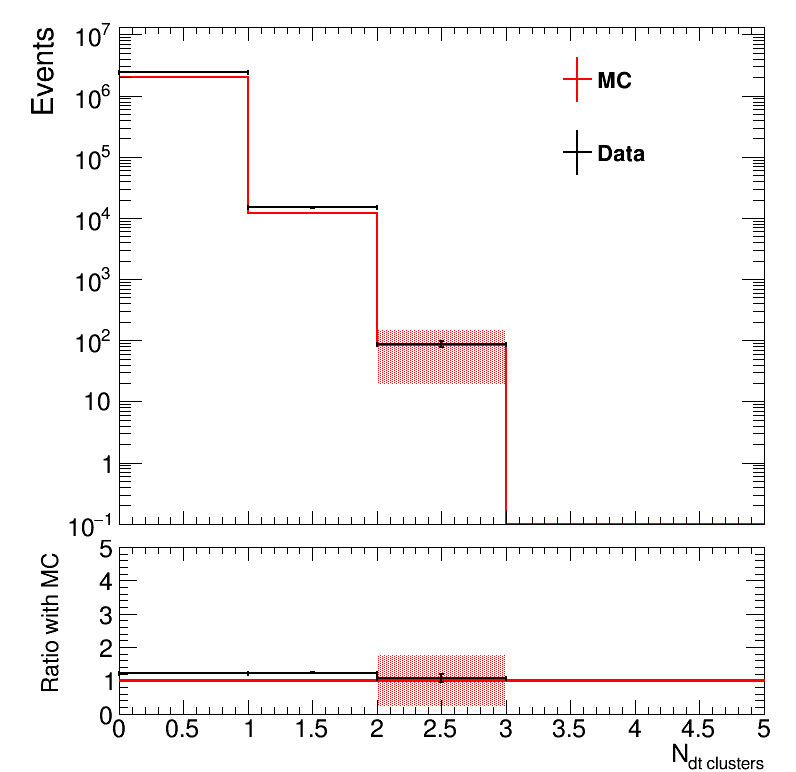

In [132]:
# plot data/mc comparison with only single electron selection

import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

var = [met, lepPt, lepEta, lepPhi, nCscRechitClusters3, nDtRechitClusters]
varName = ['met', 'lepPt', 'lepEta', 'lepPhi', 'nCscClusters','nDtClusters']
xaxis = ['met[GeV]', 'lep p_{T} [GeV]', 'lep #eta [GeV]', 'lep #phi', 'N_{csc clusters}','N_{dt clusters}']
bins = [[50,0,300],[50,0,500],[50,-2.5,2.5],[50,-3.5,3.5],[5,0,5],[5,0,5]]
logy_option = [1,1,0,0,1,1]
drawShape = False
for i, v in enumerate(var):
#     if not i == 4:continue
    leg = rt.TLegend(0.6,0.5,0.90,0.92)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    c = rt.TCanvas('c','c', 800, 800)
    rt.gStyle.SetOptFit(1011)
    h = {}
    
    for j, k in enumerate(tree_bkg.keys()):
#         if not 'wjets' in k:continue
#         h[k] = create_TH1D( v[k], axis_title=[xaxis[i], 'Events'], name='h', binning=bins[i],weights=weight[k])
        if k == 'WJetsToLNu':
            h[k] = create_TH1D( v[k], axis_title=[xaxis[i], 'Events'], name='h', binning=bins[i],weights=weight[k]*gWPtWeight[k])
            if i == 5:h[k] = create_TH1D( v[k], axis_title=[xaxis[i], 'Events'], name='h', binning=bins[i],weights=weight[k]*gWPtWeight[k]*weight_clusterEffDt[k])
            elif i == 4:h[k] = create_TH1D( v[k], axis_title=[xaxis[i], 'Events'], name='h', binning=bins[i],weights=weight[k]*gWPtWeight[k])
        else: h[k] = create_TH1D( v[k], axis_title=[xaxis[i], 'Events'], name='h', binning=bins[i])
        
        
        
        h[k].SetLineColor(std_color_list[j])
        if drawShape and h[k].Integral()>0: h[k].Scale(1./h[k].Integral())
        else: 
            if not 'data' in k:h[k].Scale(939/137000)
        for binx in range(5):
            print(k,h[k].GetBinContent(binx+1))
        leg.AddEntry(h[k],k)
        h[k].Draw('same hist')
    
    leg.Draw()
    c.SetRightMargin(0)
    c.SetLogy()
    c = make_ratio_plot([h['WJetsToLNu'],h['data']], fit = False, logy=logy_option[i], in_tags = ["MC","Data"], ratio_bounds = [0,5], draw_opt = ['E2','E1']) 
    outputDir = os.getenv('HOME')+'/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/HNL/WJetsToLNu_data_comparison/'
    
    c.SaveAs(outputDir+varName[i]+'.png')
    c.SaveAs(outputDir+varName[i]+'.pdf')
    c.SaveAs(outputDir+varName[i]+'.C')        
    c.Draw()



# Data/MC plots with ncluster>0 selection

Warning in <TFile::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/HNL/WJetsToLNu_data_comparison/met_nDtClustergt0_corr.png has been created
Info in <TCanvas::Print>: pdf file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/HNL/WJetsToLNu_data_comparison/met_nDtClustergt0_corr.pdf has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/HNL/WJetsToLNu_data_comparison/met_nDtClustergt0_corr.C has been generated


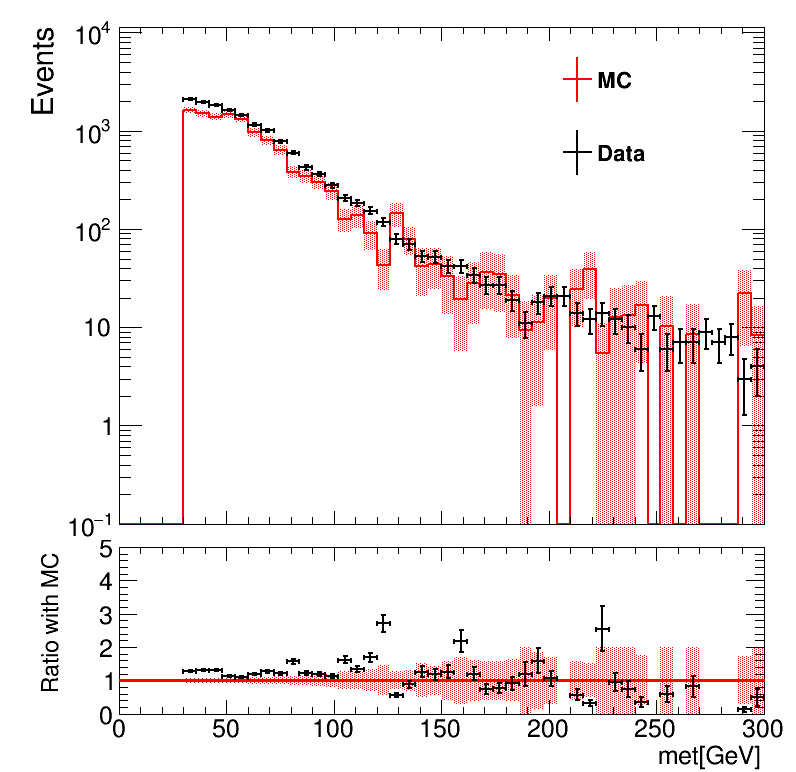

In [135]:
# data/mc comparison with ncluster>0 selection

import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

var = [met, lepPt, lepEta, lepPhi, nCscRechitClusters3, nDtRechitClusters]
varName = ['met', 'lepPt', 'lepEta', 'lepPhi', 'nCscClusters','nDtClusters']
xaxis = ['met[GeV]', 'lep p_{T} [GeV]', 'lep #eta [GeV]', 'lep #phi', 'N_{csc clusters}','N_{dt clusters}']
bins = [[50,0,300],[50,0,500],[50,-2.5,2.5],[50,-3.5,3.5],[5,0,5],[5,0,5]]
logy_option = [1,1,0,0,1,1]
drawShape = False
for i, v in enumerate(var):
    if not i == 0:continue
    leg = rt.TLegend(0.6,0.5,0.90,0.92)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    c = rt.TCanvas('c','c', 800, 800)
    rt.gStyle.SetOptFit(1011)
    h = {}
    
    for j, k in enumerate(tree_bkg.keys()):
#         if not 'wjets' in k:continue
#         h[k] = create_TH1D( v[k], axis_title=[xaxis[i], 'Events'], name='h', binning=bins[i],weights=weight[k])
        if k == 'WJetsToLNu':
            h[k] = create_TH1D( v[k][nDtRechitClusters[k]>0], axis_title=[xaxis[i], 'Events'], name='h', binning=bins[i],weights=(weight[k]*gWPtWeight[k]*weight_clusterEffDt[k])[nDtRechitClusters[k]>0])
#             h[k] = create_TH1D( v[k], axis_title=[xaxis[i], 'Events'], name='h', binning=bins[i],weights=weight[k])
        else: h[k] = create_TH1D( v[k][nDtRechitClusters[k]>0], axis_title=[xaxis[i], 'Events'], name='h', binning=bins[i])
#         print(k, '\t', np.sum(weight_evt[k][met[k]>200])/np.sum(weight_evt[k]))
        h[k].SetLineColor(std_color_list[j])
        if drawShape and h[k].Integral()>0: h[k].Scale(1./h[k].Integral())
        else: 
            if not 'data' in k:h[k].Scale(939/137000)
        leg.AddEntry(h[k],k)
        h[k].Draw('same hist')
    
    leg.Draw()
    c.SetRightMargin(0)
    c.SetLogy()
    c = make_ratio_plot([h['WJetsToLNu'],h['data']], fit = False, logy=logy_option[i], in_tags = ["MC","Data"], ratio_bounds = [0,5], draw_opt = ['E2','E1']) 
    outputDir = os.getenv('HOME')+'/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/HNL/WJetsToLNu_data_comparison/'
    
    c.SaveAs(outputDir+varName[i]+'_nDtClustergt0_corr.png')
    c.SaveAs(outputDir+varName[i]+'_nDtClustergt0_corr.pdf')
    c.SaveAs(outputDir+varName[i]+'_nDtClustergt0_corr.C')        
    c.Draw()

